In [ ]:
import sys
import os
import pandas as pd
import numpy as np
from itertools import combinations
from statsmodels.tsa.stattools import coint
from tqdm import tqdm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from numpy import log, polyfit, sqrt, std
from dotenv import load_dotenv

load_dotenv()

# For tracking through filtering process
def report_ticker_num(filtered_df):
    print(f"Universe ticker count: {len(filtered_df.columns.get_level_values(0).unique())}")

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from src.utils import mean_rev_assess_plot
from src.data_handler import DataHandler, align_data

## **Data Acquisition & Filtering**

To ensure reproducibility, I began by pre-loading a list of **5,151 common stock tickers** into `data/common_stock_tickers.csv`, filtered directly from Polygon’s asset database using their API. Only tickers classified as *common stocks* were retained.

To construct a high-quality dataset suitable for pair selection, model training, and backtesting, I applied a multi-step filtering process grounded in best practices from academic and industry sources:

- **Penny Stock Exclusion**:  
  Penny stocks are notoriously volatile and thinly traded, which undermines the assumptions and stability required for statistical arbitrage. Following the **SEC's official definition**, I excluded any stock with an average price below **\$5**.

- **Data Availability Threshold**:  
  Stocks with incomplete historical data are suboptimal for modeling, as missing bars lead to biased training signals and noisy residuals. I retained only those tickers that had data available for at least **90% of the maximum possible bars** over the 2-year period. This ensures robustness and consistency across our universe.

- **Liquidity Filter via Volume**:  
  To ensure that selected pairs are tradeable in realistic conditions, I filtered out illiquid stocks by calculating the **average daily trading volume** for each ticker and excluding those below the **50th percentile**. This percentile-based threshold is recommended in academic material on statistical arbitrage to balance liquidity with breadth.  
  _Source: [Xuanchi Zhu – Examining Pairs Trading Profitability (2024)](https://economics.yale.edu/sites/default/files/2024-05/Zhu_Pairs_Trading.pdf)_

Following this pipeline, **412 high-quality tickers** remained. These tickers will form the candidate universe for pair selection and model training.

All OHLCV minute-bar data was downloaded for a **3-year period (2022–2024)**. This duration strikes a balance between sample size and computational manageability, and is aligned with conventions cited in practitioner circles.

Data acquisition, processing, and validation were conducted via the `src/data_handler.py` module. The module handles:
- Fault-tolerant API fetching and multi-threading
- Cleaning anomalies such as extreme price/volume spikes and data gaps

A final key cleaning step involved dropping the **first and last 30 minutes of each trading day**, which are known for hightened volatility and irregularities in stock return patterns.  
_Source: [Baltussen, G., Da, Z., & Soebhag, A. (2025) – End-of-Day Reversal](https://www3.nd.edu/~zda/EOD.pdf)_

After cleaning, I split the data into three time segments for modeling:  
**20 months** for training, **8 months** for validation, and **8 months** for testing and simulation. These splits follow common practice in model development. For my own later use, I saved the full universe and each split in the <code>data/</code> directory in compressed Parquet format.

This rigorous filtering, cleaning, and structuring process ensures a stable and realistic data foundation for statistical arbitrage model development and evaluation.

In [ ]:
# Construct relative path to the CSV
data_dir = os.path.abspath(os.path.join('..', 'data'))
ticker_csv = os.path.join(data_dir, 'common_stock_tickers.csv')
tickers = pd.read_csv(ticker_csv)['ticker'].tolist()

# Load unaligned raw data
secret = os.getenv("POLYGON_API_KEY")
handler = DataHandler(tickers=tickers, api_key=secret)
raw_df = handler.fetch_all_to_df(start_date="2022-01-01", end_date="2024-12-31", max_workers=20) 

# For tracking through filtering process
def report_ticker_num(filtered_df):
    print(f"Universe ticker count: {len(filtered_df.columns.get_level_values(0).unique())}")

Fetching all tickers:   0%|          | 18/5151 [03:02<9:23:41,  6.59s/it]  

In [ ]:
# Filter out penny stocks as they are undesirably volatile for our strategy
threshold_price = 5
mean_close = raw_df.xs('close', level=1, axis=1).mean()
valid_tickers_price = mean_close[mean_close >= threshold_price].index.tolist()
filtered_df = raw_df[valid_tickers_price]

report_ticker_num(filtered_df)

In [ ]:
# Filter out tickers with low data availability (<90% of max)
bar_counts = {ticker: df.dropna().shape[0] for ticker, df in filtered_df.items()}
max_count = max(bar_counts.values())
min_required = 0.9 * max_count
filtered_dict = {ticker: df for ticker, df in filtered_df.items() if bar_counts[ticker] >= min_required}

# Recombine filtered dict into a DataFrame
filtered_df = pd.concat(filtered_dict.values(), axis=1, keys=filtered_dict.keys())
report_ticker_num(filtered_df)

In [ ]:
# Filter by 50th percentile in daily average volume
# to ensure stocks are highly liquid
avg_volumes = filtered_df.xs('volume', level=1, axis=1).mean()
median_volume = avg_volumes.median()
valid_tickers_volume = avg_volumes[avg_volumes >= median_volume].index.tolist()
filtered_df = filtered_df[valid_tickers_volume]

report_ticker_num(filtered_df)

In [ ]:
# Align and print final result
aligned_df = align_data(filtered_df)

report_ticker_num(filtered_df)
print(aligned_df.shape)
display(aligned_df.head())

In [ ]:
# Save data (and my train/val/test splits) for later use

# Ensure datetime index is sorted
aligned_df = aligned_df.sort_index()

train_end = "2023-08-31"
val_end = "2024-04-30"
train_df = aligned_df.loc[:train_end]
val_df = aligned_df.loc[train_end:val_end]
test_df = aligned_df.loc[val_end:]

# Save all to compressed Parquet
aligned_df.to_parquet(os.path.join(data_dir, "universe_full.parquet"), compression="brotli")
train_df.to_parquet(os.path.join(data_dir, "train.parquet"), compression="brotli")
val_df.to_parquet(os.path.join(data_dir, "val.parquet"), compression="brotli")
test_df.to_parquet(os.path.join(data_dir, "test.parquet"), compression="brotli")

## **Pair Research Pipeline Overview**

This notebook is dedicated to the **systematic discovery and filtering of candidate trading pairs** for a mean-reversion strategy based on statistical arbitrage. The broader project centers around constructing a robust pipeline for identifying equity pairs that exhibit stable, cointegrated relationships with strong mean-reverting behavior — a critical component for building a profitable long/short trading strategy.

We begin this notebook by focusing on **pair generation and correlation filtering**, which forms the foundation of the pipeline. Using minute-bar historical price data, we construct all possible unique ticker pairs from a universe of liquid equities. From this superset, we apply a correlation filter to retain only those pairs with sufficiently strong linear relationships in price movement. While correlation alone is not enough to infer long-term equilibrium (as it does not imply cointegration), it serves as a valuable first-pass filter to reduce the candidate space and computational burden in downstream testing.

The subsequent stages in the notebook will build on this reduced universe, applying statistical tests and modeling techniques to further refine the selection of viable trading pairs.

In [ ]:
TOP_N = 1000

# Load train data
train_df = pd.read_parquet("../data/train.parquet")

# Extract close prices: columns = tickers, rows = minute timestamps
close_px = train_df.xs('close', axis=1, level=1)

# Compute minute-level log returns
log_returns = np.log(close_px / close_px.shift(1))

# Compute pairwise correlation matrix
corr_matrix = log_returns.corr()

# Build list of (ticker_A, ticker_B, correlation)
pairs = []
for i, j in combinations(corr_matrix.columns, 2):
    corr = corr_matrix.loc[i, j]
    pairs.append((i, j, corr))

# Sort and take top-N by absolute correlation
pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
top_pairs_df = pd.DataFrame(pairs_sorted[:TOP_N], columns=["ticker1", "ticker2", "correlation"])

# Visualize
print(top_pairs_df.shape)
display(top_pairs_df.head())

(1000, 3)


,ticker1,ticker2,correlation
0,GOOG,GOOGL,0.956969
1,UA,UAA,0.905602
2,DAL,UAL,0.874312
3,CVX,XOM,0.864193
4,PAA,PAGP,0.861531


### **Cointegration Filtering via Engle-Granger Test**

Having reduced the universe of potential pairs through correlation screening, we now proceed to identify those with a **long-term equilibrium relationship** by applying the **Engle-Granger two-step cointegration test**.

While correlation captures short-term co-movement, it does not guarantee that the spread between two assets remains stable over time. **Cointegration** addresses this limitation by testing whether a linear combination of two non-stationary price series yields a **stationary residual**, implying the existence of a statistically mean-reverting spread.

For each candidate pair, we:

1. Regress the price series of one asset on the other using Ordinary Least Squares (OLS).
2. Perform the **Augmented Dickey-Fuller (ADF) test** on the resulting residuals to check for stationarity.

Only pairs whose residuals reject the unit root null hypothesis (i.e. pass the ADF test at a statistically significant level) are retained. This step ensures that we move forward with pairs whose spread dynamics are not just correlated, but also statistically tethered over time — a critical characteristic for mean-reversion trading strategies.


In [ ]:
# Parameters
COINT_P_THRESHOLD = 0.05  # Common threshold for cointegration significance

# Initialize list to store cointegrated pairs and their p-values
coint_results = []

# Loop through top N pairs and test for cointegration
for _, row in tqdm(top_pairs_df.iterrows(), total=len(top_pairs_df), desc="Cointegration Filtering"):
    t1, t2 = row['ticker1'], row['ticker2']
    s1 = close_px[t1]
    s2 = close_px[t2]

    # Drop rows with missing data for this pair
    pair_df = pd.concat([s1, s2], axis=1).dropna()
    
    # Perform Engle-Granger cointegration test (coint returns: score, pvalue, _)
    _, pval, _ = coint(pair_df.iloc[:, 0], pair_df.iloc[:, 1], maxlag=8)
    
    if pval < COINT_P_THRESHOLD:
        coint_results.append({
            'ticker1': t1,
            'ticker2': t2,
            'correlation': row['correlation'],
            'coint_pval': pval
        })

# Create filtered dataframe
coint_pairs_df = pd.DataFrame(coint_results)

# Sort by p-value ascending
coint_pairs_df = coint_pairs_df.sort_values("coint_pval").reset_index(drop=True)

# Print summary
print(f"Number of cointegrated pairs found: {len(coint_pairs_df)}")
display(coint_pairs_df.head())


Cointegration Filtering: 100%|██████████| 1000/1000 [13:38<00:00,  1.22it/s]

Number of cointegrated pairs found: 80


,ticker1,ticker2,correlation,coint_pval
0,GOOG,GOOGL,0.956969,1.286608e-09
1,SYF,WFC,0.667394,4.790187e-05
2,MOS,NTR,0.779727,1.301478e-04
3,HBAN,RF,0.785517,2.806400e-04
4,CZR,EXPE,0.621907,7.589943e-04


### **Spread Construction and Rolling Hedge Ratio Estimation**

For each cointegrated pair, we construct the **spread** — the stationary linear combination of the two asset prices — to be used in downstream **mean reversion assessments**.

The spread is calculated as:

$$
\text{Spread}_t = P^{(1)}_t - \beta \cdot P^{(2)}_t
$$

where $\beta$ is the hedge ratio estimated via full-sample OLS regression.

In addition to this static spread, we compute the **rolling hedge ratio** using a moving OLS window to capture the **time-varying behavior of the relationship** between the assets. This rolling beta series will be critical for our later step on **beta stability filtering**, which aims to discard pairs whose interdependence is not consistent over time — a key risk in deploying mean-reversion strategies.

This spread series becomes the core input for all subsequent assessments of mean-reverting behavior.

In [ ]:
# Parameters
ROLLING_WINDOW = 60  # window for rolling beta calculation

# Initialize list to hold spread information
spread_data = []

# Iterate over cointegrated pairs
for _, row in tqdm(coint_pairs_df.iterrows(), total=len(coint_pairs_df), desc="Constructing Spreads"):
    t1, t2 = row['ticker1'], row['ticker2']
    s1 = close_px[t1]
    s2 = close_px[t2]
    
    # Drop missing values for this pair
    pair_df = pd.concat([s1, s2], axis=1).dropna()
    pair_df.columns = ['s1', 's2']

    # Estimate hedge ratio using full sample OLS
    X = sm.add_constant(pair_df['s2'])
    model = sm.OLS(pair_df['s1'], X).fit()
    hedge_ratio = model.params['s2']

    # Construct spread: s1 - beta * s2
    pair_df['spread'] = pair_df['s1'] - hedge_ratio * pair_df['s2']

    # Vectorized rolling beta calculation
    s1_roll_mean = pair_df['s1'].rolling(window=ROLLING_WINDOW).mean()
    s2_roll_mean = pair_df['s2'].rolling(window=ROLLING_WINDOW).mean()

    cov = (pair_df['s1'] * pair_df['s2']).rolling(window=ROLLING_WINDOW).mean() - s1_roll_mean * s2_roll_mean
    var = pair_df['s2'].rolling(window=ROLLING_WINDOW).var()

    pair_df['rolling_beta'] = cov / var

    # Store results for this pair
    spread_data.append({
        'ticker1': t1,
        'ticker2': t2,
        'correlation': row['correlation'],
        'coint_pval': row['coint_pval'],
        'hedge_ratio': hedge_ratio,
        'spread_series': pair_df['spread'],
        'rolling_beta_series': pair_df['rolling_beta']
    })

# Convert to DataFrame for future filtering
spread_pairs_df = pd.DataFrame(spread_data)

# Sanity check
print(f"Constructed spreads for {len(spread_pairs_df)} pairs.")
display(spread_pairs_df.head())

Constructing Spreads: 100%|██████████| 80/80 [00:04<00:00, 19.48it/s]

Constructed spreads for 80 pairs.


,ticker1,ticker2,correlation,coint_pval,hedge_ratio,spread_series,rolling_beta_series
0,GOOG,GOOGL,0.956969,1.286608e-09,0.995701,datetime 2022-01-03 10:00:00+00:00 0.578823...,datetime 2022-01-03 10:00:00+00:00 NaN...
1,SYF,WFC,0.667394,4.790187e-05,0.859571,datetime 2022-01-03 10:00:00+00:00 4.311450...,datetime 2022-01-03 10:00:00+00:00 NaN...
2,MOS,NTR,0.779727,1.301478e-04,0.674938,datetime 2022-01-03 10:00:00+00:00 -10.81106...,datetime 2022-01-03 10:00:00+00:00 NaN...
3,HBAN,RF,0.785517,2.806400e-04,0.815314,datetime 2022-01-03 10:00:00+00:00 -2.576319...,datetime 2022-01-03 10:00:00+00:00 NaN...
4,CZR,EXPE,0.621907,7.589943e-04,0.368773,datetime 2022-01-03 10:00:00+00:00 29.01630...,datetime 2022-01-03 10:00:00+00:00 NaN...


### **Augmented Dickey-Fuller (ADF) Test for Mean Reversion**

Having constructed the spread series for each co-integrated pair, we now assess the strength of mean reversion by applying the Augmented Dickey-Fuller (ADF) test to each spread.

The ADF test evaluates the null hypothesis that a unit root is present in the time series, implying non-stationarity. A significantly negative ADF statistic and low p-value provide statistical evidence in favor of stationarity — a desirable property for mean-reverting strategies.

Only pairs with p-values below a defined threshold are retained for further analysis, ensuring that selected spreads exhibit strong mean-reversion characteristics consistent with a stationary process.

In [ ]:
# Parameters
ADF_P_THRESHOLD = 0.05

adf_results = []

# Iterate over pairs and test their spreads
for _, row in tqdm(spread_pairs_df.iterrows(), total=len(spread_pairs_df), desc="ADF Test on Spreads"):
    spread = row['spread_series']
    
    # ADF test returns test_statistic, pvalue, etc.
    adf_stat, pval, _, _, _, _ = adfuller(spread, maxlag=8)

    if pval < ADF_P_THRESHOLD:
        adf_results.append({
            'ticker1': row['ticker1'],
            'ticker2': row['ticker2'],
            'correlation': row['correlation'],
            'coint_pval': row['coint_pval'],
            'hedge_ratio': row['hedge_ratio'],
            'adf_stat': adf_stat,
            'adf_pval': pval,
            'spread_series': row['spread_series'],
            'rolling_beta_series': row['rolling_beta_series']
        })

# Convert to filtered DataFrame and sort by ADF p-val
adf_pairs_df = pd.DataFrame(adf_results)
adf_pairs_df = adf_pairs_df.sort_values("adf_pval").reset_index(drop=True)

# Summary
print(f"Number of mean-reverting spreads: {len(adf_pairs_df)}")
display(adf_pairs_df.head())

ADF Test on Spreads: 100%|██████████| 80/80 [00:54<00:00,  1.47it/s]

Number of mean-reverting spreads: 80


,ticker1,ticker2,correlation,coint_pval,hedge_ratio,adf_stat,adf_pval,spread_series,rolling_beta_series
0,GOOG,GOOGL,0.956969,1.286608e-09,0.995701,-7.342108,1.058552e-10,datetime 2022-01-03 10:00:00+00:00 0.578823...,datetime 2022-01-03 10:00:00+00:00 NaN...
1,SYF,WFC,0.667394,4.790187e-05,0.859571,-5.283826,5.914252e-06,datetime 2022-01-03 10:00:00+00:00 4.311450...,datetime 2022-01-03 10:00:00+00:00 NaN...
2,MOS,NTR,0.779727,1.301478e-04,0.674938,-5.055240,1.723479e-05,datetime 2022-01-03 10:00:00+00:00 -10.81106...,datetime 2022-01-03 10:00:00+00:00 NaN...
3,HBAN,RF,0.785517,2.806400e-04,0.815314,-4.872388,3.945725e-05,datetime 2022-01-03 10:00:00+00:00 -2.576319...,datetime 2022-01-03 10:00:00+00:00 NaN...
4,CZR,EXPE,0.621907,7.589943e-04,0.368773,-4.624575,1.163473e-04,datetime 2022-01-03 10:00:00+00:00 29.01630...,datetime 2022-01-03 10:00:00+00:00 NaN...


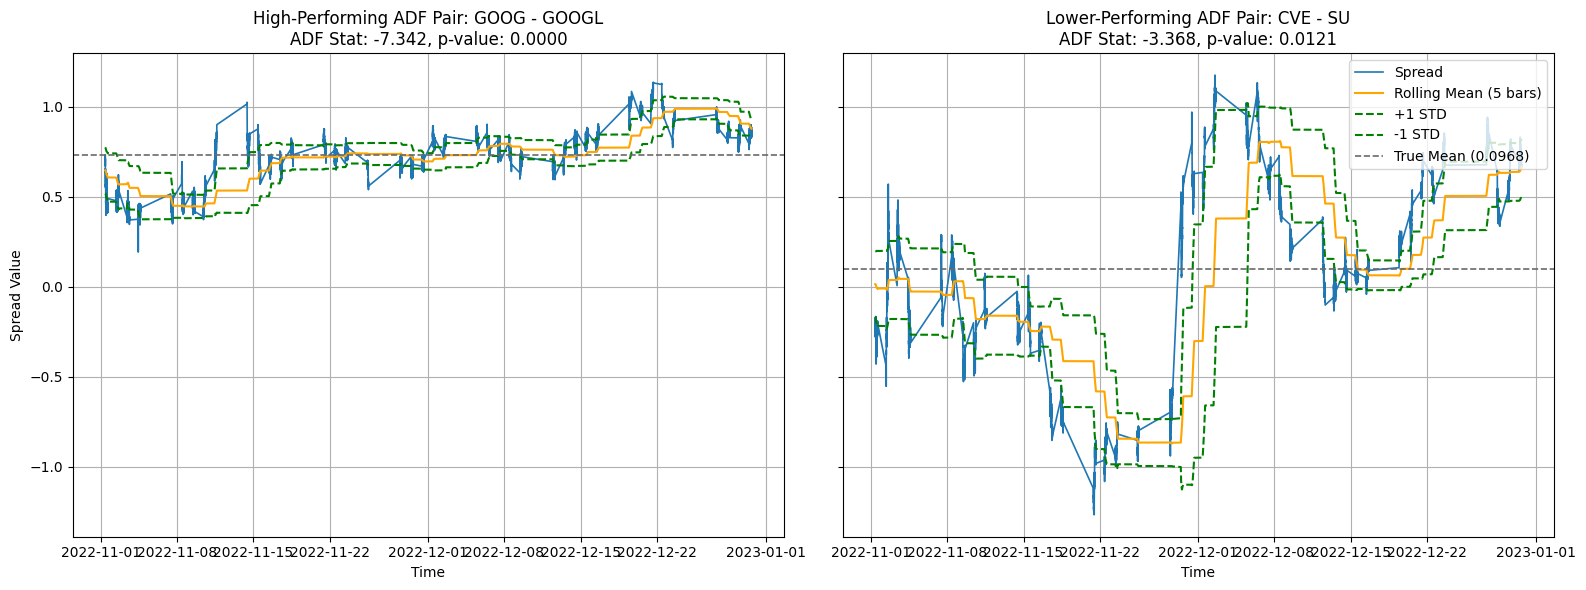

In [ ]:
# Sanity Check / Visualization

ROLLING_WINDOW = 5  # in days
start_date = '2022-11-01'  # Define a zoom window
end_date = '2023-01-01'
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # Set up subplots

mean_rev_assess_plot(
    rolling_window=ROLLING_WINDOW,
    start_date=start_date,
    end_date=end_date,
    pairs={
        'High-Performing': adf_pairs_df.iloc[0],
        'Lower-Performing': adf_pairs_df.iloc[-6]
    },
    axes=axes,
    metric_label="ADF",
    stat_fn=lambda row: f"ADF Stat: {row['adf_stat']:.3f}, p-value: {row['adf_pval']:.4f}"
)

#### ADF Test Visualization: Interpreting Spread Stationarity

The visualizations above provide a qualitative assessment of spread stationarity for two co-integrated pairs that passed the ADF test. Both pairs demonstrate mean-reverting behavior, with observable deviations around a central tendency that provide potential trading opportunities.

The left panel (Pair 1) shows a tightly oscillating spread around its rolling mean, with relatively narrow volatility bands. This tight clustering is indicative of strong and persistent mean reversion — characteristics that typically lead to a lower ADF statistic and higher confidence in stationarity.

In contrast, the right panel (Pair 2) features wider oscillations and a more variable spread trajectory. While noisier, the spread continues to revert toward its mean over time, especially within the local analysis window. This behavior, although less robust, remains consistent with the statistical result of a stationary process.

These plots highlight the value of combining statistical filtering with visual inspection to understand the dynamic characteristics of candidate spreads. Not all spreads with similar p-values behave identically, and graphical analysis offers additional insight into their suitability for trading strategies.

GOOG-GOOGL vs CVE-SU **REMOVE ME**

### **Half-Life Analysis and Strategy Adjustment**

Initially, the strategy was designed with the assumption of intraday mean reversion. To assess the viability of this, I computed the empirical half-life of mean reversion for each cointegrated pair.

The half-life of mean reversion refers to the expected time it takes for a spread to revert halfway back to its mean after a deviation. It is estimated by fitting an Ornstein-Uhlenbeck process to the spread and calculating the decay rate of mean reversion. A shorter half-life indicates faster reversion, which is more suitable for high-frequency strategies, while longer half-lives favor swing or multi-day trading approaches.

As shown in the histogram below, the majority of viable pairs exhibited half-lives in the range of **4 to 13 days**, rather than within a single trading day.

Based on this insight, I pivoted to an **intraday and multi-day strategy** that allows holding positions over multiple sessions (This will be reflected in <code>src/strategy.py</code>). This enables us to take advantage of high quality and persistent reversion signals without being constrained by the close of the trading day.

Half-Life Calculation: 100%|██████████| 80/80 [00:03<00:00, 26.24it/s]


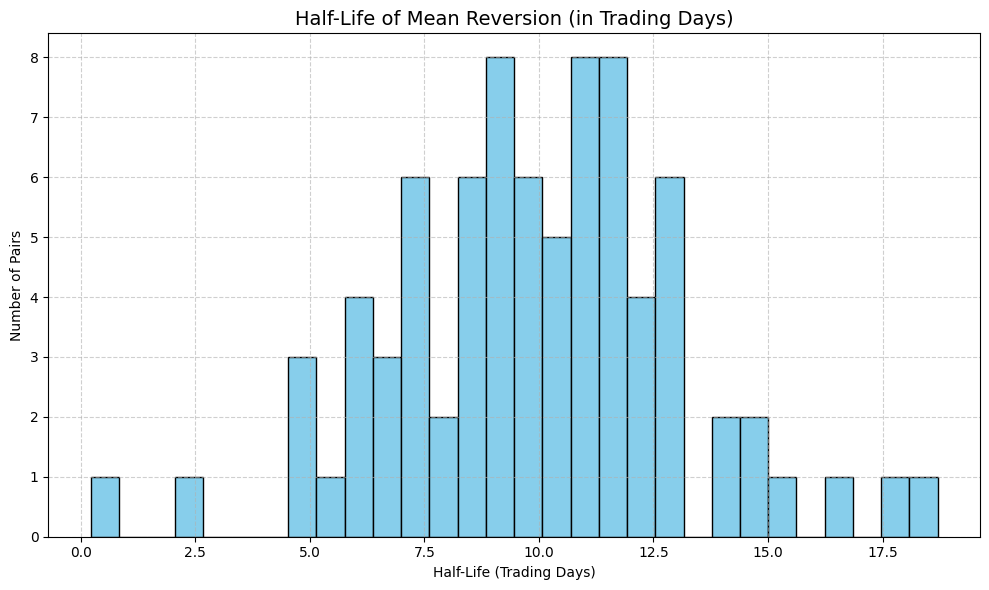

In [ ]:
hlf_minutes = []

# Iterate over candidate pairs' spreads
for _, row in tqdm(adf_pairs_df.iterrows(), total=len(adf_pairs_df), desc="Half-Life Calculation"):
    spread = row['spread_series']

    # Create lagged and delta spread
    lagged_spread = spread.shift(1).dropna()
    delta_spread = spread.diff().dropna()

    # Align lengths
    lagged_spread = lagged_spread.loc[delta_spread.index]

    # Regress delta spread ~ lagged_spread
    X = sm.add_constant(lagged_spread)
    model = sm.OLS(delta_spread, X).fit()
    phi = model.params.iloc[1]

    # Calculate half-life (in minutes)
    half_life = -np.log(2) / phi if phi < 0 else np.inf
    hlf_minutes.append(half_life)

# Add to DataFrame
adf_pairs_df['half_life_minutes'] = hlf_minutes
# Convert half-life from minutes to trading days (5.5 hrs/day due to dropped open/close)
adf_pairs_df['half_life_days'] = adf_pairs_df['half_life_minutes'] / (60 * 5.5)


# Histogram plot
plt.figure(figsize=(10, 6))
plt.hist(adf_pairs_df['half_life_days'].replace([np.inf, -np.inf], np.nan).dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Half-Life of Mean Reversion (in Trading Days)', fontsize=14)
plt.xlabel('Half-Life (Trading Days)')
plt.ylabel('Number of Pairs')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### **Hurst Exponent Analysis and Filtering**

To further assess the mean-reverting characteristics of the candidate spreads, I computed the **Hurst Exponent** for each. The Hurst Exponent \( H \) is a statistical measure of a time series’ long-term memory and persistence:

- \( H < 0.5 \): Mean-reverting behavior  
- \( H = 0.5 \): Geometric random walk (no memory)  
- \( H > 0.5 \): Trending behavior

A low Hurst value strengthens our confidence in the stationarity and reversion of the spread, which are essential properties for statistical arbitrage strategies.

I applied a conservative threshold of \( H < 0.5 \) to retain only spreads with significant mean-reverting tendencies. This step helps eliminate pairs that may have passed cointegration and ADF tests but still exhibit excessive trend-following behavior or noise in practice.

In [ ]:
# Set Hurst threshold
HURST_THRESHOLD = 0.5

def compute_hurst(series, max_lag=100):
    lags = range(2, max_lag)
    tau = [sqrt(std(series.diff(lag).dropna())) for lag in lags]
    poly = polyfit(log(lags), log(tau), 1)
    return poly[0]  # Hurst exponent

hurst_results = []

# Analyze each pair
for _, row in tqdm(adf_pairs_df.iterrows(), total=len(adf_pairs_df), desc="Hurst Filtering"):
    spread = row['spread_series']
    hurst = compute_hurst(spread)

    # Tag and store result
    row = row.copy()
    row['hurst'] = hurst
    if hurst < HURST_THRESHOLD:  # Filter by Hurst exponent
        hurst_results.append(row)

# Create filtered DataFrame
hurst_pairs_df = pd.DataFrame(hurst_results).reset_index(drop=True)

# Summary
print(f"Number of pairs passing Hurst filter: {len(hurst_pairs_df)}")
display(hurst_pairs_df[['ticker1', 'ticker2', 'hurst']].head())


Hurst Filtering: 100%|██████████| 80/80 [00:31<00:00,  2.52it/s]

Number of pairs passing Hurst filter: 80


,ticker1,ticker2,hurst
0,GOOG,GOOGL,0.132554
1,SYF,WFC,0.245991
2,MOS,NTR,0.237614
3,HBAN,RF,0.241685
4,CZR,EXPE,0.251325


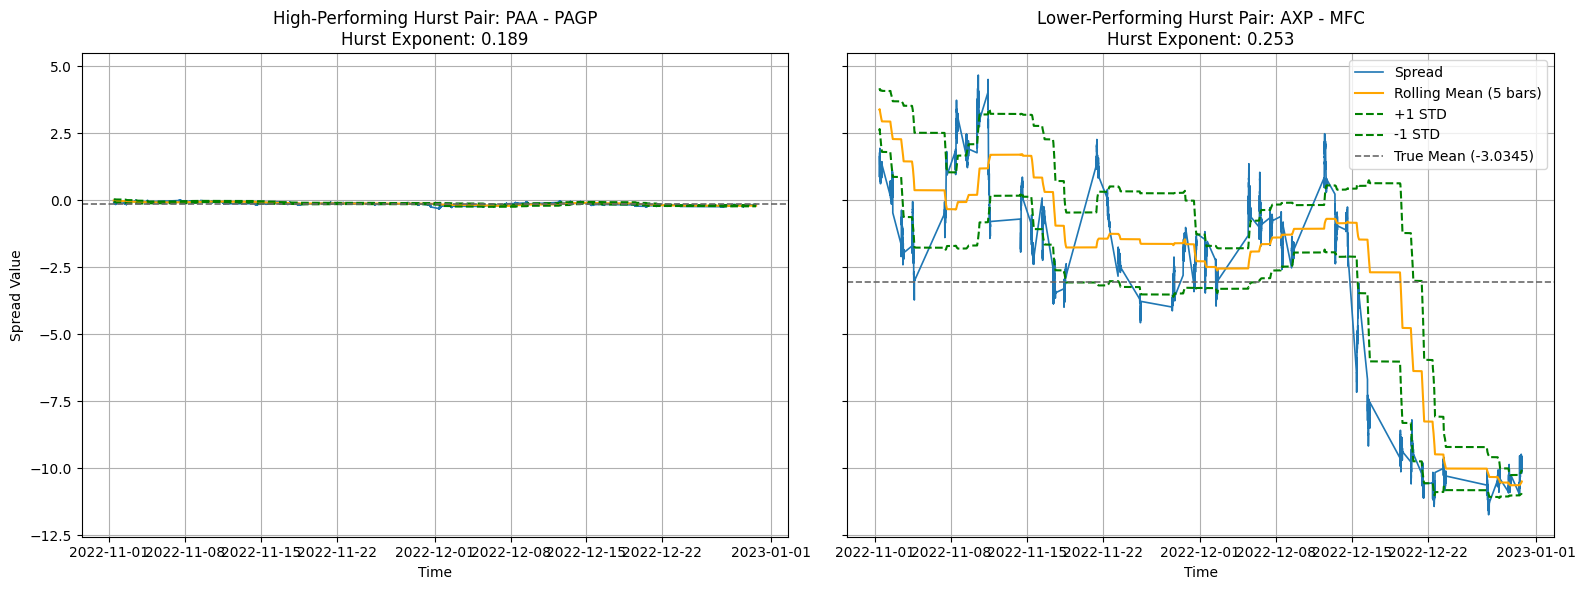

In [ ]:
# Sanity Check / Visualization

ROLLING_WINDOW = 5  # in days
start_date = '2022-11-01'  # Define a zoom window
end_date = '2023-01-01'
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # Set up subplots

mean_rev_assess_plot(
    rolling_window=ROLLING_WINDOW,
    start_date=start_date,
    end_date=end_date,
    pairs={
        'High-Performing': hurst_pairs_df.sort_values('hurst').iloc[1],  # plot second best since we've already visualized GOOG-GOOGL
        'Lower-Performing': hurst_pairs_df.sort_values('hurst').iloc[-3]
    },
    axes=axes,
    metric_label="Hurst",
    stat_fn=lambda row: f"Hurst Exponent: {row['hurst']:.3f}"
)

#### Hurst Spread Visualization and Interpretation

In the visualization below, we compare a high-performing Hurst pair (left) and a lower-performing one (right). The first pair exhibits extremely tight mean reversion, with very minimal deviation from the true mean and consistently bounded movements. This behavior reflects a stable, stationary spread that reliably returns to equilibrium, which are ideal characteristics for mean reversion strategies.

In contrast, while the second pair still demonstrates signs of mean reversion, its spread oscillates more broadly and ultimately diverges significantly from its mean in the latter portion of the window. Although this pair passed the Hurst filtering threshold, such deviation may suggest instability or drifting behavior in the spread, which is an undesirable trait for reliable arbitrage.

To address this concern, next we'll take a more critical look at the pair relationships.

PAA-PAGP vs AXP-MFC **REMOVE ME**

### **Beta Stability Analysis and Filtering**

While cointegration confirms a long-run equilibrium relationship between two assets, the **stability of that relationship over time** is equally critical for a reliable mean reversion strategy. Specifically, the hedge ratio, or beta, must remain relatively stable to ensure that the spread continues to reflect a consistent pricing relationship.

To assess this, we examine the **rolling beta series** for each candidate pair, previously calculated using a moving window of historical data. Pairs exhibiting high volatility in their beta series may indicate structural instability or changing market dynamics, which could undermine the effectiveness of the spread as a trading signal.

We quantify beta stability by computing the **standard deviation** of the rolling beta series. Pairs with excessive beta volatility are filtered out, preserving only those with consistent hedge ratios over time. This step helps ensure that our final set of pairs maintains both statistical soundness and practical reliability during simulation.

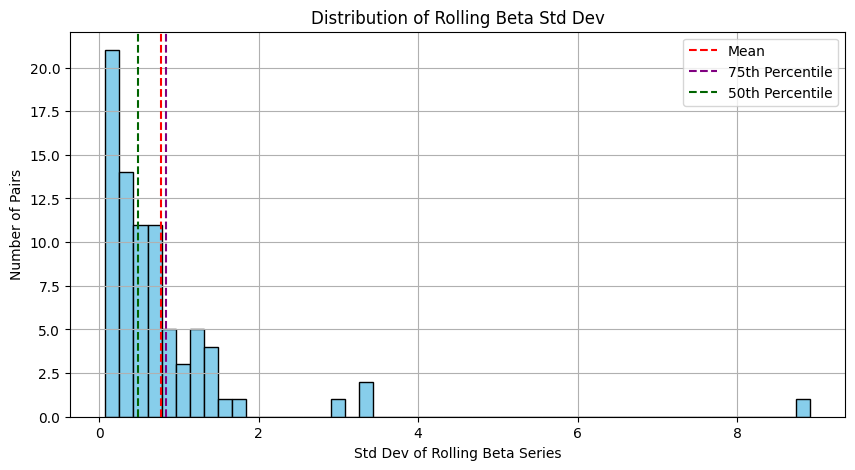

count    80.000000
mean      0.780068
std       1.123185
min       0.076838
25%       0.252147
50%       0.487852
75%       0.834329
max       8.911419
Name: rolling_beta_std, dtype: float64


In [ ]:
# Compute std dev of rolling beta for each pair
spread_pairs_df['rolling_beta_std'] = spread_pairs_df['rolling_beta_series'].apply(lambda s: s.std())

# Histogram
plt.figure(figsize=(10, 5))
plt.hist(spread_pairs_df['rolling_beta_std'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(spread_pairs_df['rolling_beta_std'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(0.834329, color='purple', linestyle='--', label='75th Percentile')
plt.axvline(0.487852, color='darkgreen', linestyle='--', label='50th Percentile')
plt.title("Distribution of Rolling Beta Std Dev")
plt.xlabel("Std Dev of Rolling Beta Series")
plt.ylabel("Number of Pairs")
plt.legend()
plt.grid(True)
plt.show()

print(spread_pairs_df['rolling_beta_std'].describe())


#### Beta Stability Threshold Selection

The histogram above displays the distribution of the standard deviations of rolling beta series across all remaining candidate pairs.

While the distribution is skewed right with a few high-volatility outliers, the majority of pairs cluster below 1.0. To strike a balance between conservativeness and breadth, I selected the **50th percentile** (median) as the filtering threshold. This ensures that only the most stable half of the pairs are retained for final consideration, aligning with the strategy’s emphasis on robustness and structural consistency.

In [ ]:
# Calculate rolling beta std devs
spread_pairs_df['rolling_beta_std'] = spread_pairs_df['rolling_beta_series'].apply(lambda s: s.dropna().std())

# Compute 50th percentile threshold
beta_std_threshold = np.percentile(spread_pairs_df['rolling_beta_std'], 50)

# Filter pairs
stable_beta_df = spread_pairs_df[spread_pairs_df['rolling_beta_std'] <= beta_std_threshold].reset_index(drop=True)
filtered_out_df = spread_pairs_df[spread_pairs_df['rolling_beta_std'] > beta_std_threshold].reset_index(drop=True)

print(f"Selected {len(stable_beta_df)} pairs with stable beta (≤ {beta_std_threshold:.4f})")

# Sort by stability (lowest std first)
stable_beta_df = stable_beta_df.sort_values(by='rolling_beta_std').reset_index(drop=True)
filtered_out_df = filtered_out_df.sort_values(by='rolling_beta_std').reset_index(drop=True)
display(stable_beta_df[['ticker1', 'ticker2', 'rolling_beta_std']].head())

Selected 40 pairs with stable beta (≤ 0.4879)


,ticker1,ticker2,rolling_beta_std
0,KMI,PSX,0.076838
1,GOOG,GOOGL,0.079834
2,KMI,MPC,0.081188
3,KMI,XOM,0.090884
4,CVE,VLO,0.110950


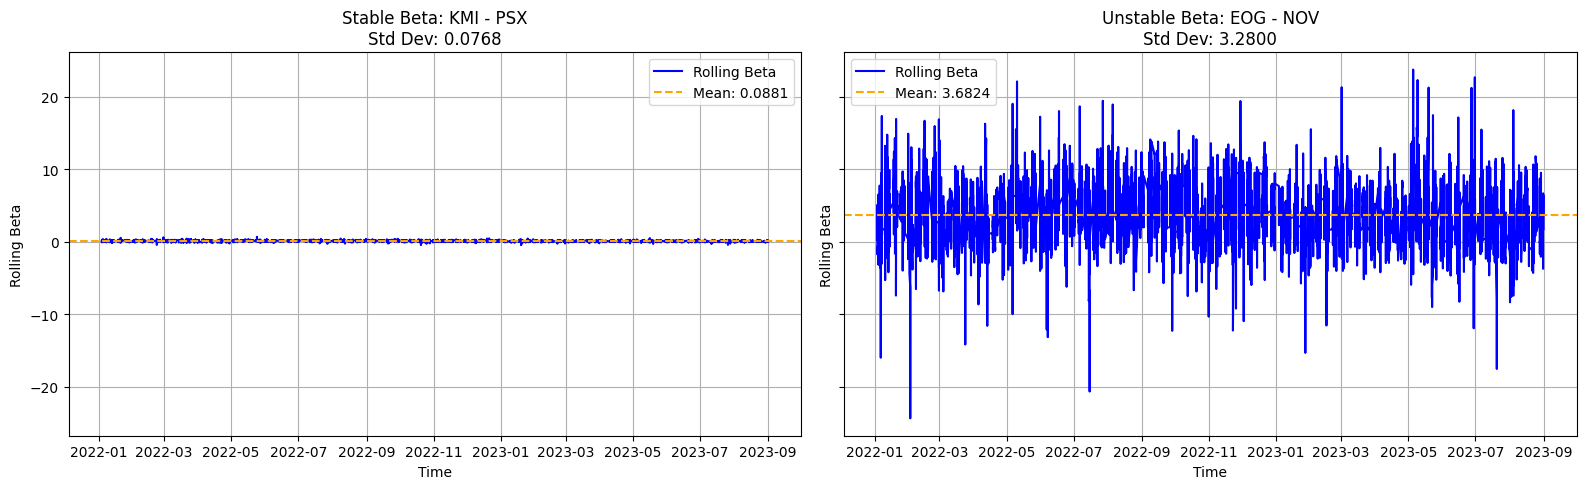

In [ ]:
# Choose one high performer and one unstable beta pair
high_row = stable_beta_df.iloc[0]
low_row = filtered_out_df.iloc[-3]

# Subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Helper plotting function
def plot_rolling_beta(ax, row, title):
    beta_series = row['rolling_beta_series'].dropna()
    ax.plot(beta_series.index, beta_series, label='Rolling Beta', color='blue')
    ax.axhline(beta_series.mean(), color='orange', linestyle='--', label=f'Mean: {beta_series.mean():.4f}')
    ax.set_title(f"{title}: {row['ticker1']} - {row['ticker2']}\nStd Dev: {beta_series.std():.4f}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Rolling Beta")
    ax.grid(True)
    ax.legend()

# Plot both
plot_rolling_beta(axes[0], high_row, "Stable Beta")
plot_rolling_beta(axes[1], low_row, "Unstable Beta")

plt.tight_layout()
plt.show()

#### Rolling Beta Visualization: Stable vs. Unstable Pairs

The chart above compares two pairs from opposite ends of the rolling beta stability spectrum. The left panel illustrates the beta series of a highly stable pair (**KMI - PSX**) with a standard deviation of just **0.0768**, while the right panel shows a pair with extreme instability (**EOG - NOV**), exhibiting a standard deviation of **3.2800**.

The stable pair maintains a consistent beta tightly centered around its mean, reflecting structural consistency in the hedge ratio. In contrast, the unstable pair experiences dramatic fluctuations in beta, increasing the likelihood of inaccurate spread construction and noise or false signals degrading strategy performance. This underscores the importance of filtering based on beta stability to ensure reliable and predictable behavior during execution.

### **Final Summary**

Through a rigorous and multi-stage statistical filtering process—including correlation screening, cointegration testing, mean-reversion validation, and beta stability assessment—we have distilled a large initial universe of candidate pairs into a refined selection of **40 high-quality trading pairs**.

These pairs exhibit the structural and statistical characteristics necessary to support a robust mean-reversion strategy, including strong co-integration relationships, consistent spread behavior, and stable hedge ratios. This curated universe now serves as the foundation for strategy development, backtesting, and execution.

I saved the final list of pairs in <code>data/final_pairs.csv</code> and a dataframe of final pairs along with their filtration metrics in <code>data/final_pair_metrics.parquet</code> for reproducibility and later use.

In [ ]:
# From stable_beta_df
beta_metrics = stable_beta_df[['ticker1', 'ticker2', 'correlation', 'coint_pval', 'rolling_beta_std']]

# From hurst_pairs_df
hurst_metrics = hurst_pairs_df[['ticker1', 'ticker2', 'hurst']]

# From adf_pairs_df
adf_metrics = adf_pairs_df[['ticker1', 'ticker2', 'adf_stat', 'half_life_minutes', 'half_life_days']]

# Merge all three on ticker1 and ticker2
final_pair_metrics_df = (
    beta_metrics
    .merge(hurst_metrics, on=['ticker1', 'ticker2'], how='inner')
    .merge(adf_metrics, on=['ticker1', 'ticker2'], how='inner')
)

# Reorder columns for readability
final_pair_metrics_df = final_pair_metrics_df[['ticker1', 'ticker2', 'correlation', 'coint_pval', 'adf_stat',
    'half_life_minutes', 'half_life_days', 'hurst', 'rolling_beta_std']]

# Save statically
final_pair_metrics_df.to_csv(os.path.join(data_dir, "final_pair_metrics.csv"), index=False)
final_pair_metrics_df[['ticker1', 'ticker2']].to_csv(os.path.join(data_dir, "final_pairs.csv"), index=False)